# Import der Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from tslearn.clustering import TimeSeriesKMeans

In [2]:
train = np.load('./train.npz')
test = np.load('./test.npz')

In [3]:
X_train = train['X']
y_train = train['y']
X_test = test['X']
y_test = test['y']

Print the shape of the preprocessed X to check the data

In [4]:
# print first row
X_train.shape

(33887, 43, 13)

As we can see there are 33887 samples with 13 features each and a 43 datapoints per sample. The 13 Features correspond to:

Accelometer X, Y, Z, Mag X, Y, Z, Gyro X, Y, Z, Orientation X, Y, Z, Orientation W

To use these features we need to preprocess them. First of all we calculate the combined lenght of all the directions for each sensor.

In [5]:
def combineAxisOnSensors(input):
    s, n, f = input.shape
    output = np.zeros((s, n, 4))
    # for each sample, sum rows 0-2
    output[:, :, 0] = input[:, :, 0] + input[:, :, 1] + input[:, :, 2]
    # for each sample, sum rows 3-5
    output[:, :, 1] = input[:, :, 3] + input[:, :, 4] + input[:, :, 5]
    # for each sample, sum rows 6-8
    output[:, :, 2] = input[:, :, 6] + input[:, :, 7] + input[:, :, 8]
    # for each sample, sum rows 9-12
    output[:, :, 3] = input[:, :, 9] + input[:, :, 10] + input[:, :, 11] + input[:, :, 12]
    return output

def combineAxisOnSensorsEuclidLength(input):
    s, n, f = input.shape
    output = np.zeros((s, n, 4))
    # for each sample, sum rows 0-2
    output[:, :, 0] = np.sqrt(input[:, :, 0] ** 2 + input[:, :, 1] ** 2 + input[:, :, 2] ** 2)
    # for each sample, sum rows 3-5
    output[:, :, 1] = np.sqrt(input[:, :, 3] ** 2 + input[:, :, 4] ** 2 + input[:, :, 5] ** 2)
    # for each sample, sum rows 6-8
    output[:, :, 2] = np.sqrt(input[:, :, 6] ** 2 + input[:, :, 7] ** 2 + input[:, :, 8] ** 2)
    # for each sample, sum rows 9-12
    output[:, :, 3] = np.sqrt(input[:, :, 9] ** 2 + input[:, :, 10] ** 2 + input[:, :, 11] ** 2 + input[:, :, 12] ** 2)
    return output

Next we want to calculate the only the difference between each datapoint.

In [6]:
def createDiffPerSample(input): # TODO: vectorize
    s, n, f = input.shape
    output = np.zeros((s, n, f))
    # calculate the differnce between each sample
    for i in range(s):
        for j in range(n):
            for k in range(f):
                if j == 0:
                    output[i, j, k] = 0
                else:
                    output[i, j, k] = abs(input[i, j-1, k] - input[i, j, k])

    return output

In [7]:
combinedOnSensors = combineAxisOnSensors(X_train)

In [8]:
#diffs = createDiffPerSample(combinedOnSensors)
diffs = combinedOnSensors

Um uns einmal ein Sample anzuschauen, werden wird das erste Sample plotten.

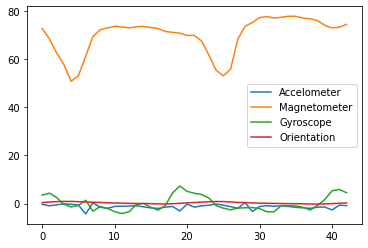

In [9]:
# print first row
plt.plot(diffs[0, :, 0], label = "Accelometer")
plt.plot(diffs[0, :, 1], label = "Magnetometer")
plt.plot(diffs[0, :, 2], label = "Gyroscope")
plt.plot(diffs[0, :, 3], label = "Orientation")
plt.legend()
plt.show()

Nun werden wir pro Sensor ein Clustering Modell trainieren, um die Zeitreihen zu Parameterisieren.

In [10]:
from tslearn.clustering import KernelKMeans
seed = 420

In [12]:
def fit_time_series_clustering(input): # TODO: optimise this function
    models = []
    for i in range(4):
        print("fitting model number {}".format(i))
        model = TimeSeriesKMeans(n_clusters=7, metric="dtw",
                                 max_iter=5, random_state=seed, verbose=True, n_jobs=-1)  # use 7 clusters cause we have 7 activities
        model.fit(input[:, :, i])
        models.append(model)
    return models

In [13]:
def fit_kernel_clustering(input): # TODO: optimise this function
    models = []
    for i in range(4):
        print("fitting model number {}".format(i))
        model = KernelKMeans(n_clusters=7,
                      kernel="gak",
                      kernel_params={"sigma": "auto"},
                      n_init=20,
                      verbose=True,
                      random_state=seed,
                      n_jobs=-1)  # use 7 clusters cause we have 7 activities
        model.fit(input[:, :, i])
        models.append(model)
    return models

In [13]:
# fit the model
models = fit_time_series_clustering(diffs)

fitting model number 0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 11230 tasks 

16.439 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 11230 tasks 

12.267 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 11230 tasks 

11.688 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 11230 tasks 

11.408 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 11230 tasks 

11.256 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 11230 tasks 

fitting model number 1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 11230 tasks 

62724.315 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 11230 tasks 

41500.922 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 11230 tasks 

40822.337 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 11230 tasks 

40591.250 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 11230 tasks 

40551.375 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 11230 tasks 

fitting model number 2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 11230 tasks 

56.439 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 11230 tasks 

44.271 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 11230 tasks 

43.057 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 11230 tasks 

42.671 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 11230 tasks 

42.482 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 11230 tasks 

fitting model number 3


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 11230 tasks 

4.491 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 11230 tasks 

2.439 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 11230 tasks 

2.287 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 11230 tasks 

2.252 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 11230 tasks 

2.235 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 11230 tasks 

In [14]:
# method to get the distances from the centroids to each sample
def get_distances(models, input):
    distances = []
    for i in range(4):
        distances.append(models[i].transform(input[:, :, i]))
    
    # stack distances horizontally
    distances = np.hstack(distances)
    return distances

In [15]:
dists = get_distances(models, diffs)

/Users/flavio/opt/anaconda3/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 33887 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:

Show centroids

NameError: name 'models' is not defined

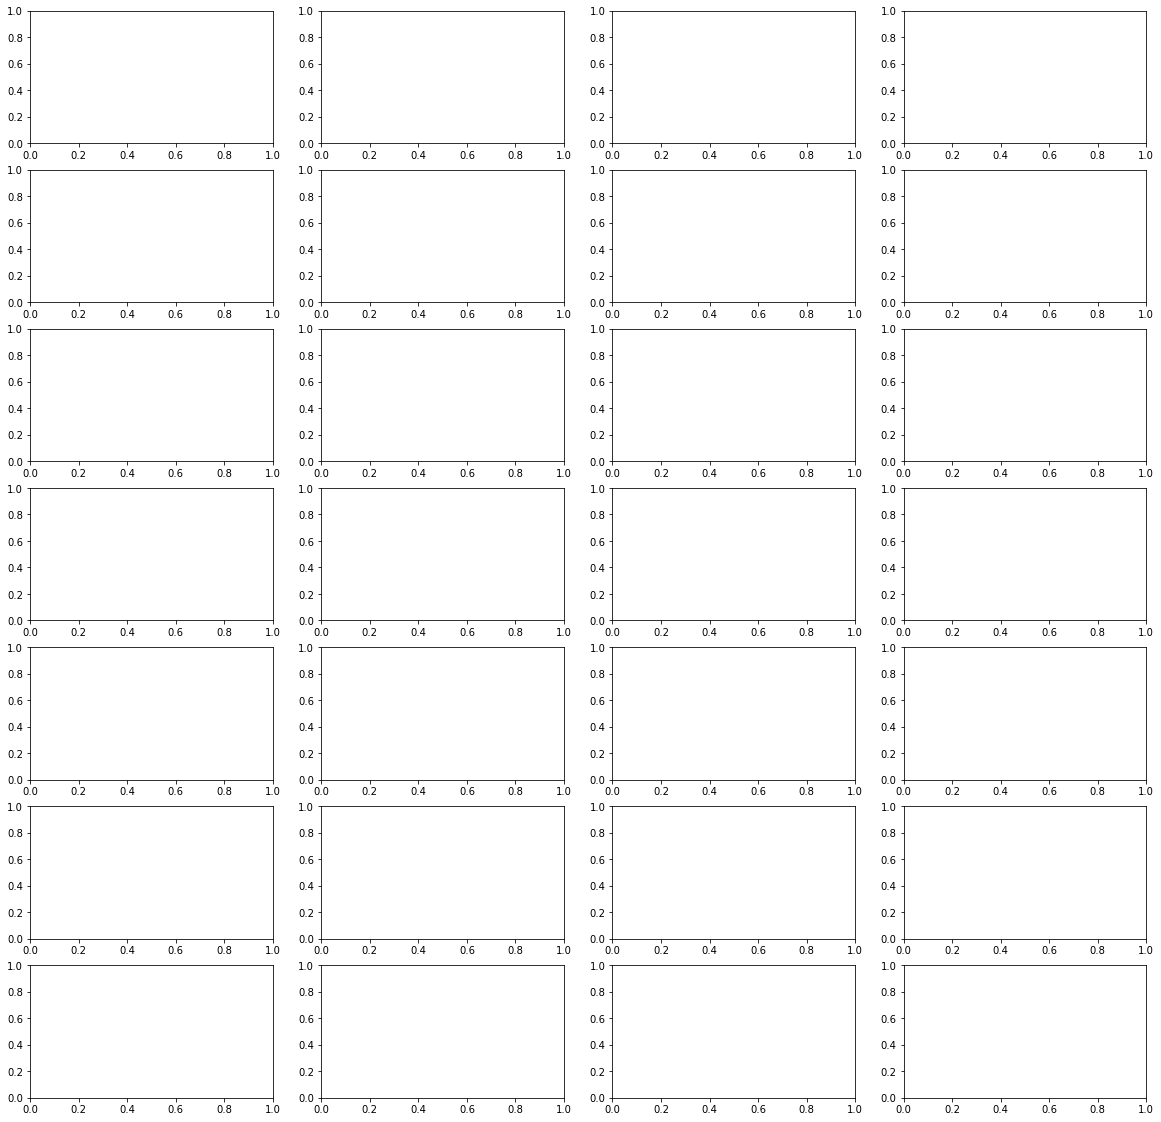

In [17]:
# init subplots for centroids
fig, ax = plt.subplots(7, 4, figsize=(20, 20))

# model names
model_names = ["Accelerometer", "Magnetometer", "Gyroscope", "Orientation"]

# plot the centroids for each model
for i in range(4):
    for j in range(7):
        ax[j, i].plot(models[i].cluster_centers_[j])
        
    # set the tiltle per column of subplot
    ax[0, i].set_title(model_names[i])

In [21]:
# import random forest


In [17]:
random_forest = RandomForestClassifier(random_state=seed)

# create random forest grid search
param_grid = {
    'n_estimators': [100, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [15, 45],
    'min_samples_split': [2, 10],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

# run gridSerach
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5, n_jobs=-1, verbose=5)

In [18]:
# fit the model
grid_search.fit(dists, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV 5/5] END bootstrap=True, criterion=gini, max_depth=15, max_features=auto, min_samples_split=2, n_estimators=100; total time=  11.8s
[CV 4/5] END bootstrap=True, criterion=gini, max_depth=15, max_features=auto, min_samples_split=2, n_estimators=100; total time=  11.9s
[CV 1/5] END bootstrap=True, criterion=gini, max_depth=15, max_features=auto, min_samples_split=2, n_estimators=100; total time=  12.0s
[CV 3/5] END bootstrap=True, criterion=gini, max_depth=15, max_features=auto, min_samples_split=2, n_estimators=100; total time=  12.0s
[CV 2/5] END bootstrap=True, criterion=gini, max_depth=15, max_features=auto, min_samples_split=2, n_estimators=100; total time=  12.4s
[CV 1/5] END bootstrap=True, criterion=gini, max_depth=15, max_features=auto, min_samples_split=10, n_estimators=100; total time=  11.8s
[CV 4/5] END bootstrap=True, criterion=gini, max_depth=15, max_features=auto, min_samples_split=10, n_estimators=100; tot

/Users/flavio/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 2/5] END bootstrap=False, criterion=entropy, max_depth=15, max_features=log2, min_samples_split=2, n_estimators=300; total time= 1.4min
[CV 3/5] END bootstrap=False, criterion=entropy, max_depth=15, max_features=log2, min_samples_split=2, n_estimators=300; total time= 1.4min
[CV 4/5] END bootstrap=False, criterion=entropy, max_depth=15, max_features=log2, min_samples_split=2, n_estimators=300; total time= 1.5min
[CV 5/5] END bootstrap=False, criterion=entropy, max_depth=15, max_features=log2, min_samples_split=2, n_estimators=300; total time= 1.5min
[CV 1/5] END bootstrap=False, criterion=entropy, max_depth=45, max_features=auto, min_samples_split=2, n_estimators=100; total time=  35.7s
[CV 2/5] END bootstrap=False, criterion=entropy, max_depth=45, max_features=auto, min_samples_split=2, n_estimators=100; total time=  36.2s
[CV 3/5] END bootstrap=False, criterion=entropy, max_depth=45, max_features=auto, min_samples_split=2, n_estimators=100; total time=  37.0s
[CV 4/5] END bootstr

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=420),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [15, 45],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [2, 10],
                         'n_estimators': [100, 300]},
             verbose=5)

In [19]:
# prepare test data
combinedOnSensorsTest = combineAxisOnSensors(X_test)
diffsTest = combinedOnSensorsTest #createDiffPerSample(combinedOnSensorsTest)
distsTest = get_distances(models, diffsTest)

/Users/flavio/opt/anaconda3/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 8472 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed: 

In [20]:
# get test score of random forest
grid_search.score(distsTest, y_test)

0.9089943342776204

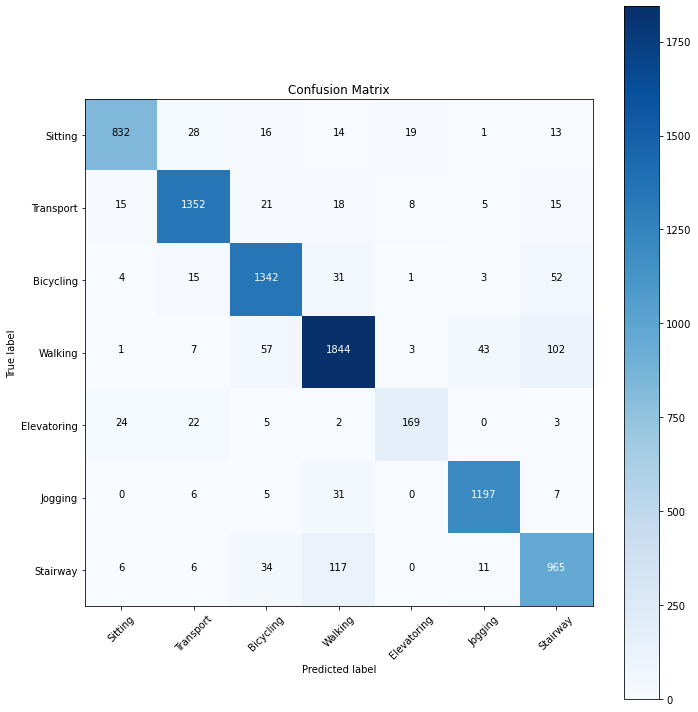

In [26]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix

import itertools
# import matplotlib.pyplot as plt


# get the predictions
y_pred = grid_search.predict(distsTest)

# plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# show confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(7)
labels = ['Sitting', 'Transport', 'Bicycling', 'Walking', 'Elevatoring', 'Jogging', 'Stairway']
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

# show numbers in plot
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.show()

# Test mit normalisierten Daten

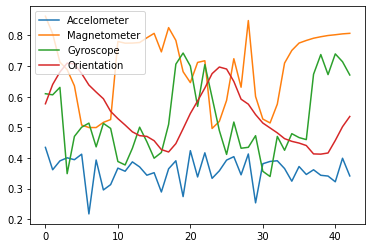

In [10]:
# normalize data
from sklearn.preprocessing import MinMaxScaler

# normalize X_test and X_train per column
scaler = MinMaxScaler((0, 1))

# fit scaler on each column of combinedOnSensors
combinedOnSensors = combineAxisOnSensors(X_train)
for i in range(4):
    scaler.fit(combinedOnSensors[:, :, i])
    combinedOnSensors[:, :, i] = scaler.transform(combinedOnSensors[:, :, i])

# fit scaler on each column of combinedOnSensorsTest
combinedOnSensorsTest = combineAxisOnSensors(X_test)
for i in range(4):
    scaler.fit(combinedOnSensorsTest[:, :, i])
    combinedOnSensorsTest[:, :, i] = scaler.transform(combinedOnSensorsTest[:, :, i])


# combine on Sensors
plt.plot(combinedOnSensors[0, :, 0], label = "Accelometer")
plt.plot(combinedOnSensors[0, :, 1], label = "Magnetometer")
plt.plot(combinedOnSensors[0, :, 2], label = "Gyroscope")
plt.plot(combinedOnSensors[0, :, 3], label = "Orientation")
plt.legend()
plt.show()

In [15]:
# fit the knn models
normalized_models = fit_time_series_clustering(combinedOnSensors)

fitting model number 0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 11230 tasks 

0.040 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 11230 tasks 

0.033 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 11230 tasks 

0.032 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 11230 tasks 

0.032 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 11230 tasks 

0.032 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 11230 tasks 

fitting model number 1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 11230 tasks 

0.003 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 11230 tasks 

0.003 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 11230 tasks 

0.003 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 11230 tasks 

0.003 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 11230 tasks 

0.003 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 11230 tasks 

fitting model number 2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 11230 tasks 

0.081 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 11230 tasks 

0.071 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 11230 tasks 

0.070 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 11230 tasks 

0.070 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 11230 tasks 

0.070 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 11230 tasks 

fitting model number 3


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 11230 tasks 

0.264 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 11230 tasks 

0.163 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 11230 tasks 

0.159 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 11230 tasks 

0.158 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 11230 tasks 

0.158 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 11230 tasks 

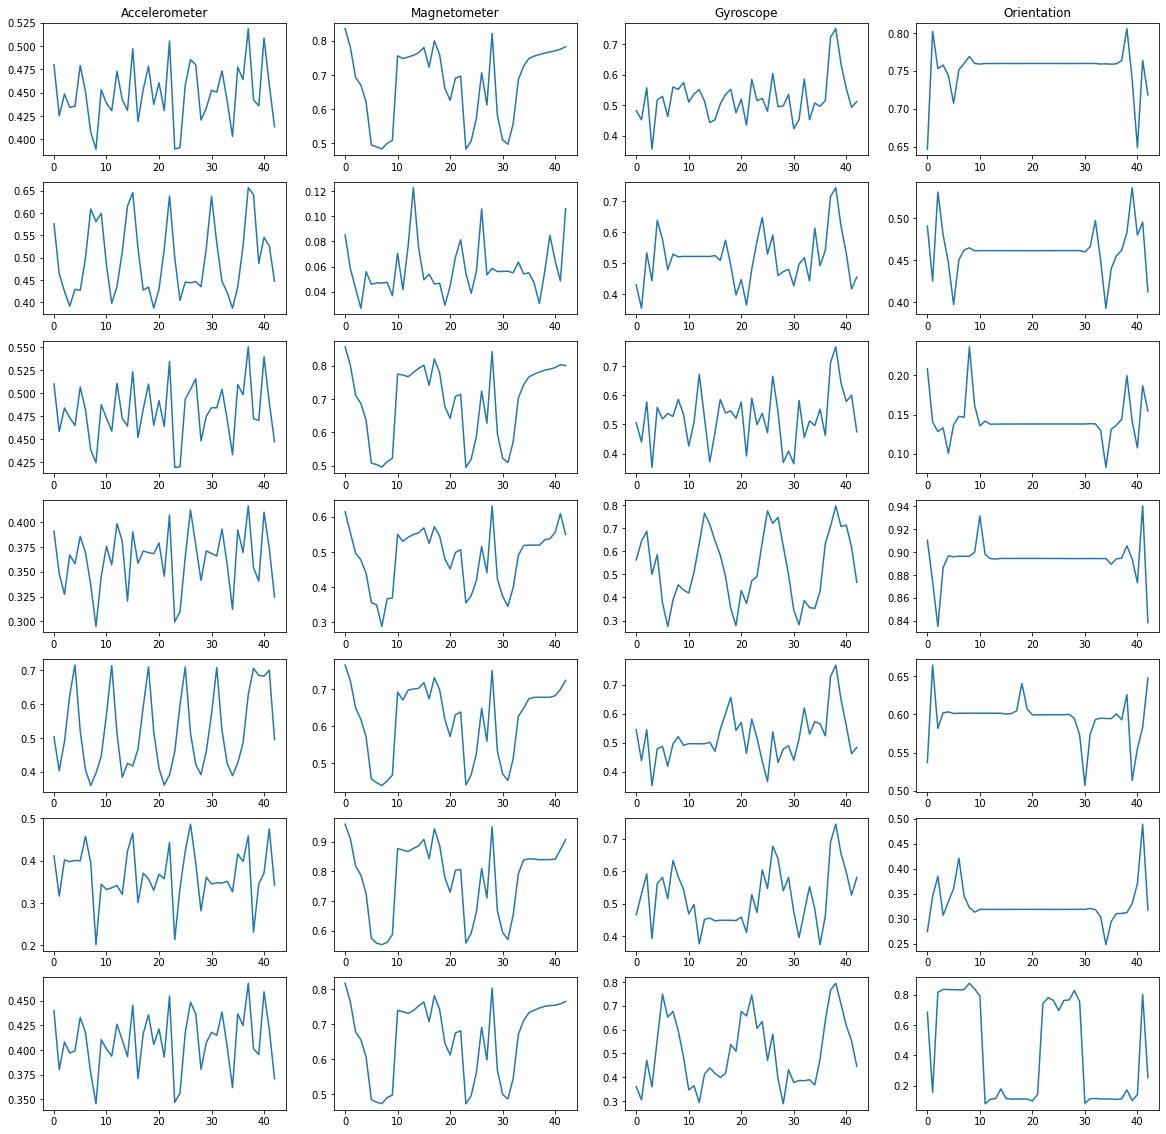

In [19]:
# plot centroids
fig, ax = plt.subplots(7, 4, figsize=(20, 20))

# plot centroids for each model
for i in range(4):
    for j in range(7):
        ax[j, i].plot(normalized_models[i].cluster_centers_[j])
        
    # set the tiltle per column of subplot
    ax[0, i].set_title(model_names[i])

In [18]:
# get distance
dists = get_distances(normalized_models, combinedOnSensors)

/Users/flavio/opt/anaconda3/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 33887 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:

In [23]:
# export dists as npz
np.savez("dists.npz", dists)

In [29]:
# train random forest
random_forest = RandomForestClassifier(random_state=seed)

# create random forest grid search
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [15, 20, 30, 45],
    'bootstrap': [True, False],
    'class_weight': ['balanced', None]
}

# run gridSerach
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5, n_jobs=-1, verbose=5)

# fit grid search
grid_search.fit(dists, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 2/5] END bootstrap=True, class_weight=balanced, max_depth=15, n_estimators=100; total time=  12.3s
[CV 1/5] END bootstrap=True, class_weight=balanced, max_depth=15, n_estimators=100; total time=  12.4s
[CV 4/5] END bootstrap=True, class_weight=balanced, max_depth=15, n_estimators=100; total time=  12.5s
[CV 3/5] END bootstrap=True, class_weight=balanced, max_depth=15, n_estimators=100; total time=  12.5s
[CV 5/5] END bootstrap=True, class_weight=balanced, max_depth=15, n_estimators=100; total time=  12.5s
[CV 2/5] END bootstrap=True, class_weight=balanced, max_depth=15, n_estimators=300; total time=  39.9s
[CV 1/5] END bootstrap=True, class_weight=balanced, max_depth=15, n_estimators=300; total time=  40.6s
[CV 4/5] END bootstrap=True, class_weight=balanced, max_depth=15, n_estimators=300; total time=  41.0s
[CV 5/5] END bootstrap=True, class_weight=balanced, max_depth=15, n_estimators=300; total time=  41.4s
[CV 3/5] EN

/Users/flavio/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 2/5] END bootstrap=True, class_weight=balanced, max_depth=20, n_estimators=500; total time= 1.1min
[CV 3/5] END bootstrap=True, class_weight=balanced, max_depth=20, n_estimators=500; total time= 1.1min
[CV 4/5] END bootstrap=True, class_weight=balanced, max_depth=20, n_estimators=500; total time= 1.1min
[CV 5/5] END bootstrap=True, class_weight=balanced, max_depth=20, n_estimators=500; total time= 1.1min
[CV 2/5] END bootstrap=True, class_weight=balanced, max_depth=30, n_estimators=300; total time=  40.2s
[CV 1/5] END bootstrap=True, class_weight=balanced, max_depth=30, n_estimators=300; total time=  41.0s
[CV 3/5] END bootstrap=True, class_weight=balanced, max_depth=30, n_estimators=300; total time=  40.4s
[CV 4/5] END bootstrap=True, class_weight=balanced, max_depth=30, n_estimators=300; total time=  41.8s
[CV 5/5] END bootstrap=True, class_weight=balanced, max_depth=30, n_estimators=300; total time=  41.6s
[CV 1/5] END bootstrap=True, class_weight=balanced, max_depth=45, n_estim

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=420),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'class_weight': ['balanced', None],
                         'max_depth': [15, 20, 30, 45],
                         'n_estimators': [100, 300, 500]},
             verbose=5)

In [25]:
import joblib
# export best grid search model
joblib.dump(grid_search.best_estimator_, 'best_grid_search_model.pkl')

['best_grid_search_model.pkl']

In [30]:
# score model of best grid search
dist_Test = get_distances(normalized_models, combinedOnSensorsTest)
grid_search.score(dist_Test, y_test)

/Users/flavio/opt/anaconda3/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 8472 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed: 

0.30004721435316334

In [31]:
grid_search.best_params_

{'bootstrap': False,
 'class_weight': 'balanced',
 'max_depth': 45,
 'n_estimators': 500}